# 0. Importing Packages

In [1]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm
import init_cfg as ic

# 1. Loading IFU Data

In [2]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var, cont
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
binned_continuum = vb['cont']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [3]:
binned_spectrum.shape

(4591, 364)

In [4]:
data0 = binned_spectrum - binned_continuum
vari0 = binned_variance
cont0 = binned_continuum

dat = data0 * (1.0+redshift)
var = vari0 * (1.0+redshift)**2.0
cont = cont0 * (1.0+redshift)

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [5]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.1*np.sum((binNpix == 1)))
print(0.1*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 1.1. Retrieving maximum spectrum

In [6]:
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)
# yInd2, xInd2 = 30, 38    # non-contaminated region
n_bin = data_vbin[yInd, xInd]
print("Maximum intensity bin")
print(f"Bin {n_bin:d}: (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = dat[:, n_bin]
maximum_variance = var[:, n_bin]
maximum_continuum = cont[:, n_bin]

Maximum intensity bin
Bin 0: (x, y) = (32, 29)


## 1.2. Retrieving integrated spectrum with the bin's order

In [7]:
n_integrate = 16
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

## 1.3. Retrieving integrated spectrum within a circle

In [8]:
fin_cb = 'bfcube_3D.fits'

d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

d_sci[:, 0, :] = 0.
d_sci[:, :, 0] = 0.
d_sci[:, -1, :] = 0.
d_sci[:, :, -1] = 0.

d_sci2 = d_sci * (1+redshift)
d_var2 = d_var * (1+redshift)**2

In [9]:
from photutils.aperture import CircularAperture as CAp
rad = 4
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci2*msk, axis=(1, 2))
circular_variance = np.sum(d_var2*msk, axis=(1, 2))
print(circular_spectrum.shape)

Area: 50.2655 = 50.2655?  True
(4591,)


<IPython.core.display.Javascript object>


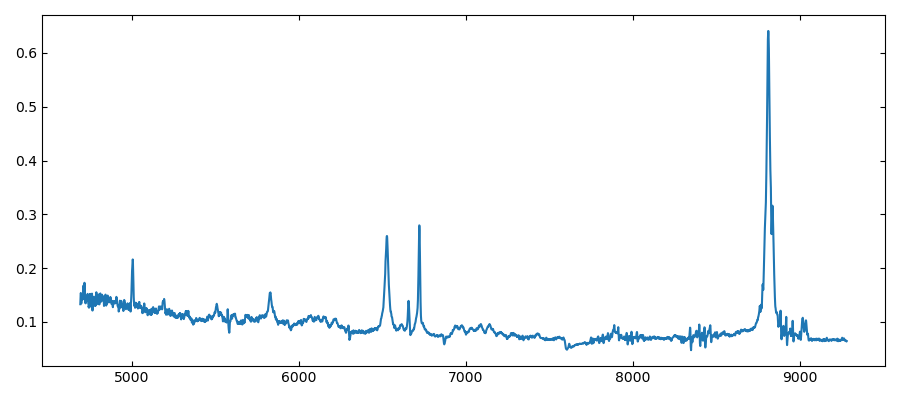

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, circular_spectrum)
plt.tight_layout()

### 1.3.1. Continuum subtraction for the circular spectrum

<IPython.core.display.Javascript object>


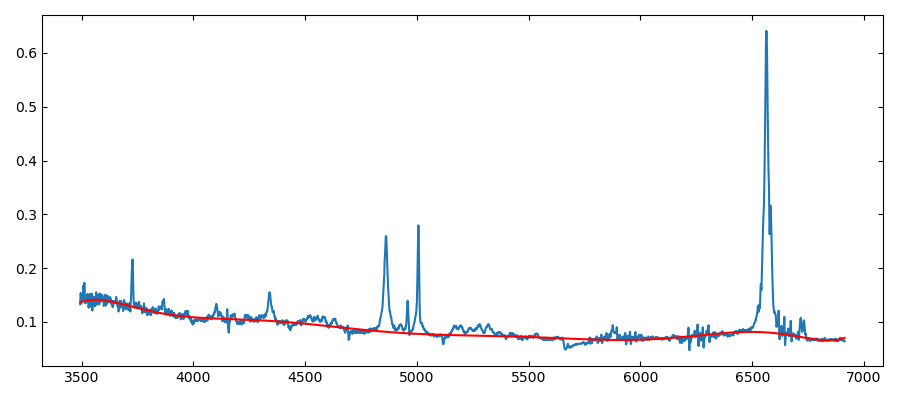

In [11]:
from specutils import Spectrum1D
from specutils.fitting import fit_continuum
from astropy import units as u
from astropy.modeling.polynomial import Chebyshev1D

# Wavelength masking range (directly copied from spec0_vbin.py)
wav_frame_mode = 'obs'    # 'obs' / 'res'
wav_msk2 = np.array([[4980, 5020],  # [OII]
                    [5150, 5210],   # [NeIII]
                    [5280, 5370],   # emission?
                    [5440, 5560],   # H delta
                    [5750, 5880],   # H gamma
                    [5970, 6320],   # noisy? region
                    [6440, 6590],   # H beta
                    [6630, 6800],    # [OIII]4959/5007
                    [6900, 7300],   # noisy? region
                    [7550, 7800],   # absorption?
                    [8600, 9100]   # [NII] + H alpha + [SII]
                    ])
if (wav_frame_mode == 'obs'):
    wav_msk2 = wav_msk2 / (1.0+redshift)
else:
    pass

# Continuum fitting: polynomial relation
region = [(wav_res.min()*u.AA, wav_msk2[0,0]*u.AA)]

for j in np.arange(wav_msk2.shape[0]-1):
    region.append((wav_msk2[j,1]*u.AA, wav_msk2[j+1,0]*u.AA))
region.append((wav_msk2[wav_msk2.shape[0]-1, 1]*u.AA, wav_res.max()*u.AA))
region = [(3600.*u.AA, 3700.*u.AA), (3750.*u.AA, 3800.*u.AA),
          (3900.*u.AA, 3950.*u.AA), (4020.*u.AA, 4050.*u.AA),
          (4270.*u.AA, 4310.*u.AA), (4380.*u.AA, 4420.*u.AA),
          (4720.*u.AA, 4820.*u.AA), (4895.*u.AA, 4915.*u.AA),
          (4935.*u.AA, 4945.*u.AA), (4965.*u.AA, 4980.*u.AA),
          (5060.*u.AA, 5110.*u.AA), (5130.*u.AA, 5140.*u.AA),
          (5400.*u.AA, 5650.*u.AA), (6020.*u.AA, 6200.*u.AA),
          (6350.*u.AA, 6500.*u.AA), (6745.*u.AA, 6885.*u.AA)]

lam = wav_res * u.AA
flx = circular_spectrum * u.Unit("1.0e-15 erg cm-2 s-1 AA-1")
tspec = Spectrum1D(spectral_axis = lam, flux = flx)
cfunc = fit_continuum(tspec, model=Chebyshev1D(10), window=region)
ccont = cfunc(tspec.spectral_axis)

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, circular_spectrum)
ax.plot(wav_res, ccont.value, '-', color='red')
plt.tight_layout()
plt.savefig("subcircular_0.png", dpi=300)

subcircular_spectrum = circular_spectrum - ccont.value
subcircular_variance = circular_variance
subcircular_continuum = ccont.value

In [12]:
mode = "maximum"
# "maximum" OR "integrated" OR "subcircular"

exec("fit_spectrum = copy.deepcopy("+mode+"_spectrum)")
exec("fit_variance = copy.deepcopy("+mode+"_variance)")
exec("fit_continuum = copy.deepcopy("+mode+"_continuum)")

<IPython.core.display.Javascript object>


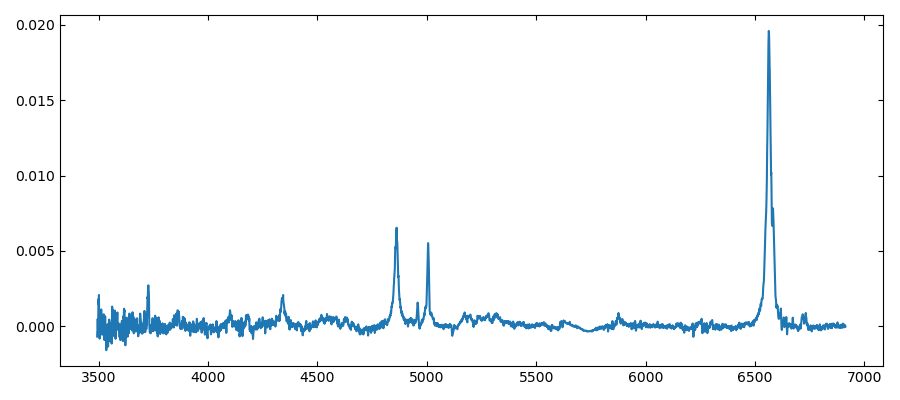

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, fit_spectrum)
plt.tight_layout()

# 2. Basic Setting of Line Fitting

In [14]:
np.random.seed(0)

In [15]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multin_gauss_cdf_scale(x, *pars, n=2, n_broad=0):
    g_i = 0
    for i in np.arange(n):
        if (i < n-n_broad):
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        else:
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[2*i+2], pars[2*i+3])
    return g_i

In [16]:
def line_par(line_numbers, broad_component = False):

    if (line_numbers == 0):
        nlines, nbroad = 1, 0  # 2, 0
        line_names = ['OII3727']#, 'OII3729']
        line_wav = [3727.092]#, 3729.875]
        line_sigma = [3.0]
        wav_fit = [3720.0, 3740.0]
    
    if (line_numbers == 1):
        if broad_component:
            nlines, nbroad = 2, 1
            line_names = ['Hbeta', 'Broad1_1']
            line_wav = [4862.68, 4862.68]
            line_sigma = [3.0, 20.0]
            wav_fit = [4810.0, 4910.0]
        else:
            nlines, nbroad = 1, 0
            line_names = ['Hbeta']
            line_wav = [4862.68]
            line_sigma = [3.0]
            wav_fit = [4855.0, 4870.0]

    if (line_numbers == 2):
        if broad_component:
            nlines, nbroad = 3, 1
            line_names = ['OIII4959', 'OIII5007', 'Broad2_1']
            line_wav = [4960.295, 5008.240, 5008.240]
            line_sigma = [3.0, 20.0]
            wav_fit = [4940.0, 5040.0]
        else:    
            nlines, nbroad = 2, 0
            line_names = ['OIII4959', 'OIII5007']
            line_wav = [4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4950.0, 5015.0]        

    if (line_numbers == 3):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1']
            line_wav = [6549.86, 6564.61, 6585.27, 6564.61]
            line_sigma = [3.0, 30.0]
            wav_fit = [6500.0, 6625.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['NII6548', 'Halpha', 'NII6584']
            line_wav = [6549.86, 6564.61, 6585.27]
            line_sigma = [3.0]
            wav_fit = [6540.0, 6595.0]

    if (line_numbers == 4):
        nlines, nbroad = 2, 0
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        line_sigma = [3.0]
        wav_fit = [6710.0, 6740.0]

    if (line_numbers == 5):
        nlines, nbroad = 1, 0
        line_names = ['OI6300']
        line_wav = [6302.046]
        line_sigma = [3.0]
        wav_fit = [6295.0, 6310.0]
    
    line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)
    
    return [nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq\n')
f.close()

broad = True
if broad:
    g = open('linefit_integrated_broad.txt','w')
    g.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq flxsum_scale\n')
    g.close()

# 3. Emission Line Fitting

## 3.1. ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

100%|██████████| 1000/1000 [00:20<00:00, 49.57it/s]


----- Narrow components -----
NII6548 mean: 6549.530 +/- 0.373 Angstrom
NII6548 sigma: 288.82 +/- 3.458 km/s
NII6548 sigma: 6.310 +/- 0.076 Angstrom
NII6548 R: 1198.90 +/- 42.63
NII6548 flux: 5.47e-02 +/- 2.67e-03
NII6548 reduced chi-square: 0.65


Halpha mean: 6563.868 +/- 0.094 Angstrom
Halpha sigma: 288.82 +/- 3.458 km/s
Halpha sigma: 6.324 +/- 0.076 Angstrom
Halpha R: 1201.55 +/- 42.68
Halpha flux: 2.61e-01 +/- 4.86e-03
Halpha reduced chi-square: 1.63


NII6584 mean: 6581.876 +/- 0.173 Angstrom
NII6584 sigma: 288.82 +/- 3.458 km/s
NII6584 sigma: 6.341 +/- 0.076 Angstrom
NII6584 R: 1204.88 +/- 42.75
NII6584 flux: 8.08e-02 +/- 2.37e-03
NII6584 reduced chi-square: 1.68


----- Broad components -----
Broad3_1 mean: 6560.238 +/- 0.671 Angstrom
Broad3_1 sigma: 1415.54 +/- 49.838 km/s
Broad3_1 sigma: 30.976 +/- 1.091 Angstrom
Broad3_1 R: 1200.88 +/- 42.67
Broad3_1 flux: 1.91e-01 +/- 7.32e-03
Broad3_1 reduced chi-square: 1.00




<IPython.core.display.Javascript object>


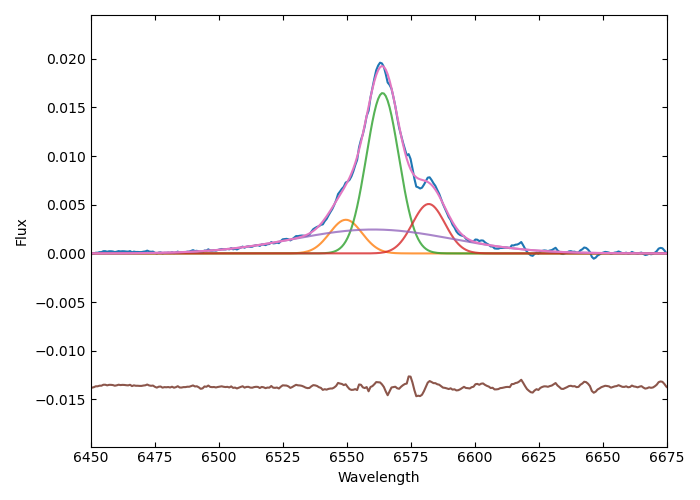

[8.78878216e+00 4.72172755e-03 1.90686492e-01]


In [17]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()
    
    
# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.2. ${\rm [SII]\lambda\lambda6717,6731}$

100%|██████████| 1000/1000 [00:02<00:00, 371.37it/s]


----- Narrow components -----
SII6717 mean: 6717.131 +/- 0.520 Angstrom
SII6717 sigma: 163.44 +/- 12.819 km/s
SII6717 sigma: 3.662 +/- 0.287 Angstrom
SII6717 R: 1229.86 +/- 43.26
SII6717 flux: 7.17e-03 +/- 6.57e-04
SII6717 reduced chi-square: 0.21


SII6731 mean: 6731.221 +/- 0.439 Angstrom
SII6731 sigma: 163.44 +/- 12.819 km/s
SII6731 sigma: 3.670 +/- 0.288 Angstrom
SII6731 R: 1232.46 +/- 43.32
SII6731 flux: 6.67e-03 +/- 6.30e-04
SII6731 reduced chi-square: 0.19




<IPython.core.display.Javascript object>


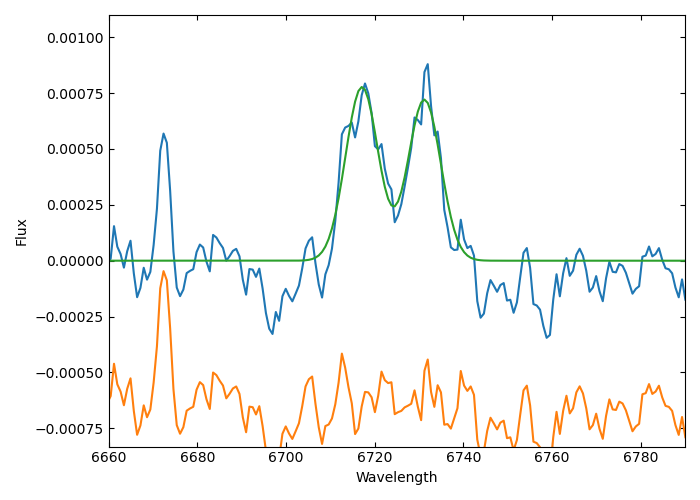

[8.78878216e+00 4.72172755e-03 1.90686492e-01]


In [18]:
# Line fitting: Monte Carlo simulation of curve_fit ([SII]6717/6731)
line_numbers = 4

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.3. ${\rm [OII]\lambda\lambda3727,3729}$

100%|██████████| 1000/1000 [00:01<00:00, 523.68it/s]


----- Narrow components -----
OII3727 mean: 3727.048 +/- 0.524 Angstrom
OII3727 sigma: 227.70 +/- 34.275 km/s
OII3727 sigma: 2.831 +/- 0.426 Angstrom
OII3727 R: 677.55 +/- 33.19
OII3727 flux: 1.99e-02 +/- 2.75e-03
OII3727 reduced chi-square: 0.18




<IPython.core.display.Javascript object>


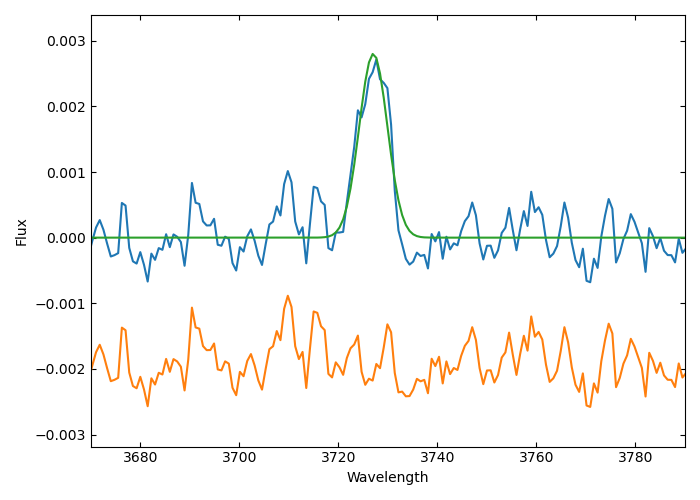

[8.78878216e+00 4.72172755e-03 1.90686492e-01]


In [19]:
# Line fitting: Monte Carlo simulation of curve_fit ([OII]3727/3729)
line_numbers = 0

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.4. ${\rm H\beta}$

100%|██████████| 1000/1000 [00:06<00:00, 161.62it/s]


----- Narrow components -----
Hbeta mean: 4861.218 +/- 0.255 Angstrom
Hbeta sigma: 397.74 +/- 36.048 km/s
Hbeta sigma: 6.449 +/- 0.585 Angstrom
Hbeta R: 887.05 +/- 36.63
Hbeta flux: 6.64e-02 +/- 1.14e-02
Hbeta reduced chi-square: 0.29


----- Broad components -----
Broad1_1 mean: 4860.500 +/- 1.584 Angstrom
Broad1_1 sigma: 1266.97 +/- 173.590 km/s
Broad1_1 sigma: 20.541 +/- 2.814 Angstrom
Broad1_1 R: 886.92 +/- 36.63
Broad1_1 flux: 1.04e-01 +/- 9.63e-03
Broad1_1 reduced chi-square: 0.19




<IPython.core.display.Javascript object>


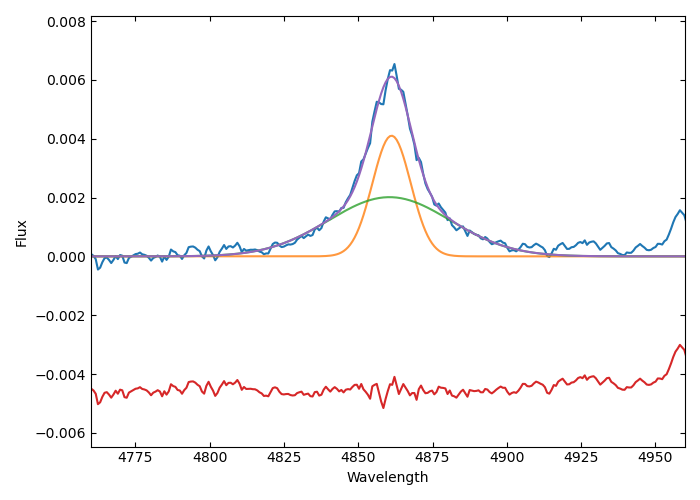

[8.48889653e+00 4.22615505e-03 1.03640651e-01]


In [20]:
# Line fitting: Monte Carlo simulation of curve_fit (H beta)
line_numbers = 1

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

## 3.5. ${\rm [OIII]\lambda\lambda4959,5007}$

100%|██████████| 1000/1000 [00:10<00:00, 99.69it/s]


----- Narrow components -----
OIII4959 mean: 4958.019 +/- 0.302 Angstrom
OIII4959 sigma: 186.11 +/- 6.964 km/s
OIII4959 sigma: 3.078 +/- 0.115 Angstrom
OIII4959 R: 904.93 +/- 36.95
OIII4959 flux: 1.17e-02 +/- 7.81e-04
OIII4959 reduced chi-square: 0.42


OIII5007 mean: 5006.200 +/- 0.125 Angstrom
OIII5007 sigma: 186.11 +/- 6.964 km/s
OIII5007 sigma: 3.108 +/- 0.116 Angstrom
OIII5007 R: 913.83 +/- 37.11
OIII5007 flux: 3.28e-02 +/- 1.71e-03
OIII5007 reduced chi-square: 0.44


----- Broad components -----
Broad2_1 mean: 5004.185 +/- 0.805 Angstrom
Broad2_1 sigma: 930.88 +/- 55.895 km/s
Broad2_1 sigma: 15.538 +/- 0.933 Angstrom
Broad2_1 R: 913.46 +/- 37.10
Broad2_1 flux: 5.14e-02 +/- 2.62e-03
Broad2_1 reduced chi-square: 0.27




<IPython.core.display.Javascript object>


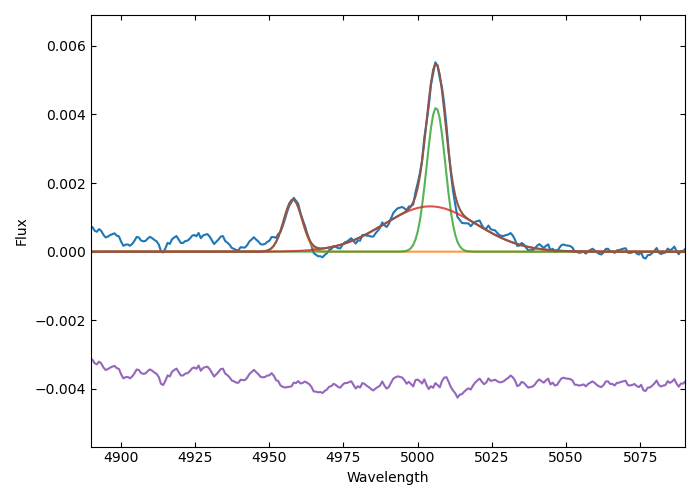

[8.51802992e+00 3.10509762e-03 5.14375087e-02]


In [21]:
# Line fitting: Monte Carlo simulation of curve_fit ([OIII]4959/5007)
line_numbers = 2

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component = True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

n_fit = 1000
mpopt = []
for i in tqdm.trange(n_fit):
    y_dat = np.random.normal(y_loc, np.sqrt(y_var))
    outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
    y_dat[outliers] = y_loc[outliers]
    y_fit = x_wav * y_dat
    
    param = [line_sigma[0] / line_wav[0]]
    for j in np.arange(nlines):
        if (j < nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        else:
            param += [np.log(line_wav[j]),
                      line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                      flx_scale0 / nlines]
    
    popt, pcov = curve_fit(line_model, x_fit, y_fit, param)
    perr = np.sqrt(np.diag(pcov))
    mpopt.append(popt)

mpar = np.mean(mpopt, axis=0)
e_mpar = np.std(mpopt, axis=0)


# Printing & writing the results
f = open('linefit_integrated.txt','a')
g = open('linefit_integrated_broad.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")
    
    if (line_names[i][:5] != 'Broad'):
        f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        f.write(f"{specR:.2f}  {e_specR:.2f}  ")
        f.write(f"{flux:.2e}  {e_flux:.2e}  ")
        f.write(f"{rchisq:.2f}\n")
    else:
        g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
        g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
        g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
        g.write(f"{specR:.2f}  {e_specR:.2f}  ")
        g.write(f"{flux:.2e}  {e_flux:.2e}  ")
        g.write(f"{rchisq:.2f}  ")
        g.write(f"{flx_scale0:.2e}\n")
f.close()
g.close()


# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()
plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

# Saving broad components
for i in np.arange(nbroad):
    mpar_b = mpar[2*(nlines-nbroad)+1:2*(nlines-nbroad)+4]
    exec(f"mpar_l{line_numbers:d}_b{i+1:d} = mpar_b")
try:
    print(mpar_b)
except NameError:
    print("No broad component.")

# 4. Additional Tasks for Broad Components

## 4.1. Creating a New Image with Gaussian Profile

In [22]:
from astropy.modeling.models import Gaussian2D
fwhm = 1.0    # arcsec
pixel_scale = 0.1    # arcsec/pix
x_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
y_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
print(x_sigma, y_sigma)
g2d = Gaussian2D(amplitude = 1, x_mean = yInd, y_mean = xInd, x_stddev = x_sigma, y_stddev = y_sigma)
img_g2d = g2d(*np.mgrid[0:d_sci.shape[1], 0:d_sci.shape[2]])

4.2466090014400955 4.2466090014400955


<IPython.core.display.Javascript object>


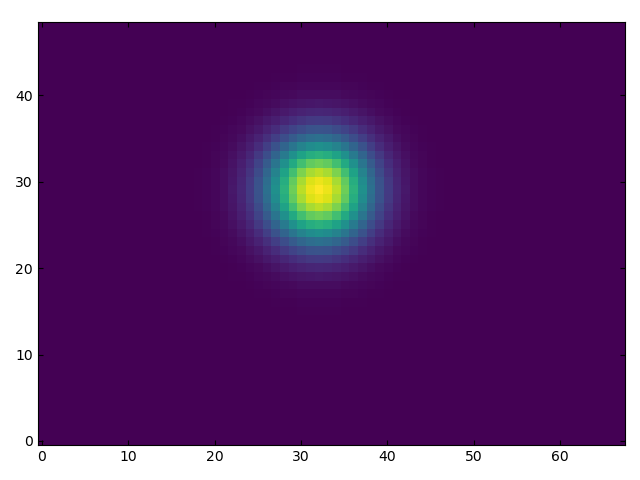

In [23]:
fig, ax = plt.subplots()
ax.imshow(img_g2d, origin = 'lower')
plt.tight_layout()

fits.writeto("g2d.fits", img_g2d, overwrite=True)

## 4.2. Checking for Spectra in an Arbitrary Bin

### 4.2.1. Setting an Arbitrary Bin

In [24]:
nbin = 323    # arbitrary bin

print(f"Bin {nbin:d}")

fit_spectrum = dat[:, nbin]
fit_variance = var[:, nbin]
fit_continuum = cont[:, nbin]

Bin 323


In [25]:
indices = np.argwhere(data_vbin == nbin)
print("The (x,y) indices of the bin")
print(indices)

The (x,y) indices of the bin
[[37 31]
 [37 32]
 [38 31]
 [38 32]]


In [26]:
npix = indices.shape[0]
print(f"Number of pixels in the bin: {npix:d}")

Number of pixels in the bin: 4


### 4.2.2. Creating an Image of Initial Guess for the Broad Component Factors

In [27]:
print("Gaussian factors of this bin:")
img_g2d[indices[:, 0], indices[:, 1]]

Gaussian factors of this bin:


array([0.16493849, 0.16957554, 0.10294888, 0.10584316])

In [28]:
fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
if (mode == "subcircular"):
    fac /= (np.sum(img_g2d*msk))
print(f"Mean Gaussian factor of broad components: {fac:.4f}")

Mean Gaussian factor of broad components: 0.1358


<IPython.core.display.Javascript object>


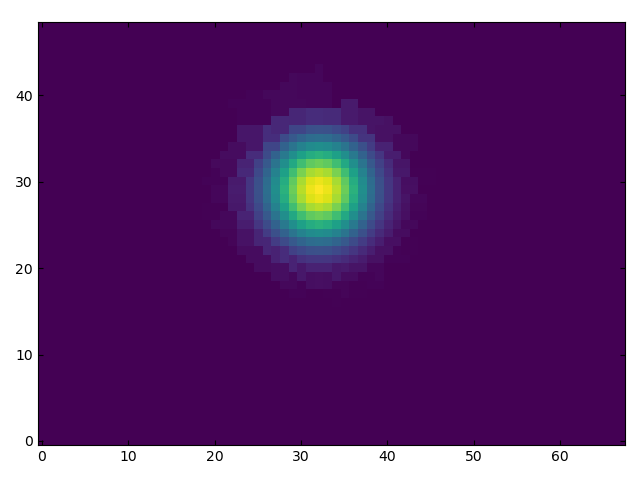

In [29]:
gfac = np.zeros_like(img_g2d)
for b in np.unique(data_vbin):
    binwhere = np.argwhere(data_vbin == b)
    if (b == -99):
        fc = 0.0
    else:
        fc = np.sum(img_g2d[binwhere[:, 0], binwhere[:, 1]])
#         fc = img_g2d[binwhere[:, 0], binwhere[:, 1]].max()
    gfac[data_vbin == b] = fc / binwhere.shape[0]
    
fig, ax = plt.subplots()
ax.imshow(gfac, origin = 'lower', vmin=0.01, vmax=1.0)
plt.tight_layout()
fits.writeto("gfac.fits", gfac, overwrite=True)

### 4.2.3. Plotting the Spectra for Visual Check

<IPython.core.display.Javascript object>


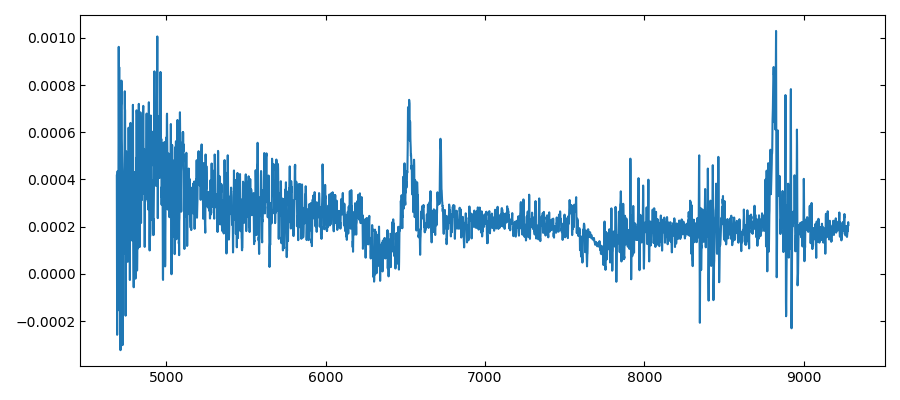

In [30]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

fig, ax = plt.subplots(figsize=(9,4))
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum)
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]))
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2]))
ax.plot(wav_obs, binned_spectrum[:, nbin] / indices.shape[0])
plt.tight_layout()

<IPython.core.display.Javascript object>


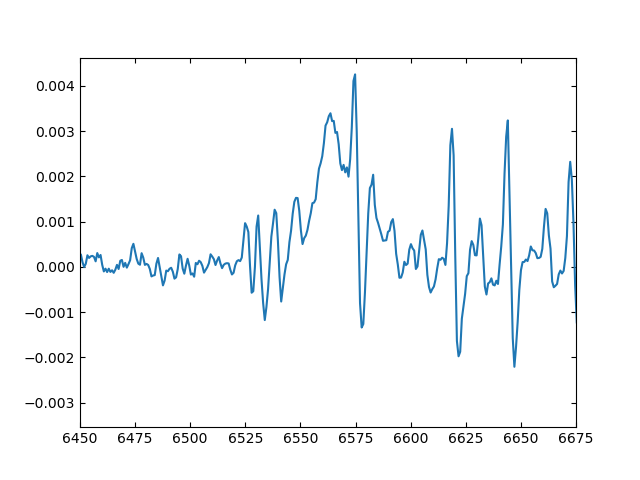

In [31]:
broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - fac*broad_plt)

### 4.2.4. Line Fitting with Fixing Broad Components

0.13582651774533336 ---> 0.05355077222826773 ---> 0.2142030889130709
0.024283618149110172
----- Narrow components -----
NII6548 mean: 6551.027 +/- 7.013 Angstrom
NII6548 sigma: 302.48 +/- 50.961 km/s
NII6548 sigma: 6.610 +/- 1.114 Angstrom
NII6548 R: 1199.18 +/- 42.63
NII6548 flux: 9.04e-03 +/- 6.32e-03
NII6548 reduced chi-square: 2.36


Halpha mean: 6566.001 +/- 1.223 Angstrom
Halpha sigma: 302.48 +/- 50.961 km/s
Halpha sigma: 6.625 +/- 1.116 Angstrom
Halpha R: 1201.95 +/- 42.69
Halpha flux: 4.93e-02 +/- 1.08e-02
Halpha reduced chi-square: 3.93


NII6584 mean: 6586.321 +/- 3.415 Angstrom
NII6584 sigma: 302.48 +/- 50.961 km/s
NII6584 sigma: 6.645 +/- 1.120 Angstrom
NII6584 R: 1205.70 +/- 42.77
NII6584 flux: 1.14e-02 +/- 4.77e-03
NII6584 reduced chi-square: 3.91


----- Broad components -----
Broad3_1 mean: 6560.238 +/- 0.000 Angstrom
Broad3_1 sigma: 1415.54 +/- 0.000 km/s
Broad3_1 sigma: 30.976 +/- 0.000 Angstrom
Broad3_1 R: 1200.88 +/- 42.67
Broad3_1 flux: 4.08e-02 +/- 1.85e-02
Broad3

<IPython.core.display.Javascript object>


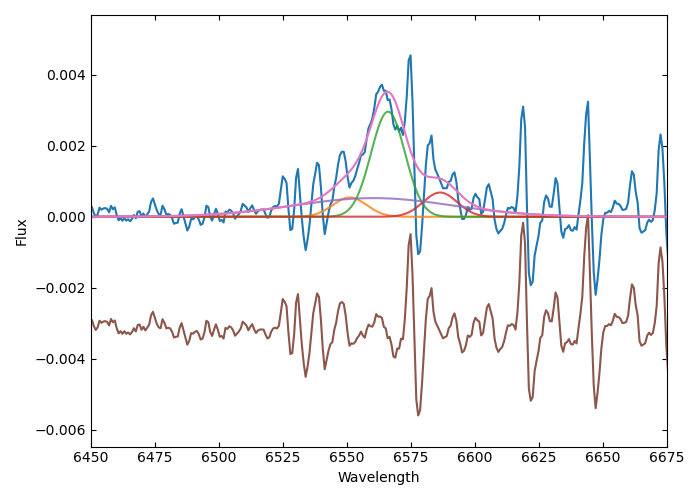

In [32]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3

nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_dat = y_loc / indices.shape[0]
flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
y_fit = x_wav * y_dat

broad_fit = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_fit += gauss_cdf_scale(x_fit, *mpar_b)
    

# Model fitting
def line_model2(x, *pars):
    narrow_comp = 0
    for i in np.arange(nlines-nbroad):
        narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
    broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
    return narrow_comp + broad_comp
    
param = [line_sigma[0] / line_wav[0]]
for j in np.arange(nlines-nbroad):
    param += [np.log(line_wav[j]), flx_scale0 / nlines]
param += [fac]

popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
perr = np.sqrt(np.diag(pcov))
mpar, e_mpar = popt, perr


# Arranging parameters
ffac = mpar[-1]
print(fac, "--->", ffac, "--->", ffac*indices.shape[0])
mpar[2::2] *= indices.shape[0]
mpar = list(mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    mpar += [mpar_b[0], mpar_b[1], ffac*mpar_b[2]*indices.shape[0]]

e_ffac = e_mpar[-1]
print(e_ffac)
e_mpar[2::2] *= indices.shape[0]
e_mpar = list(e_mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    e_mpar += [0.0, 0.0, e_ffac*mpar_b[2]*indices.shape[0]]

    
# Printing the results
# f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")

    
# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()

### 4.2.5. Check for Broad-Component-Subtracted Spectra

* ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

<IPython.core.display.Javascript object>


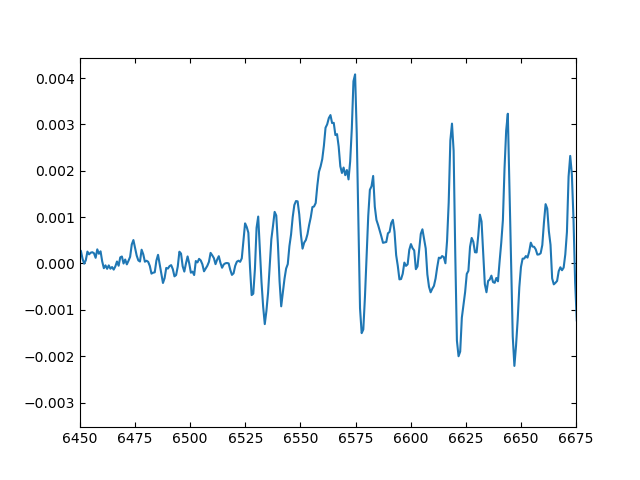

In [33]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

* ${\rm H\beta}$

<IPython.core.display.Javascript object>


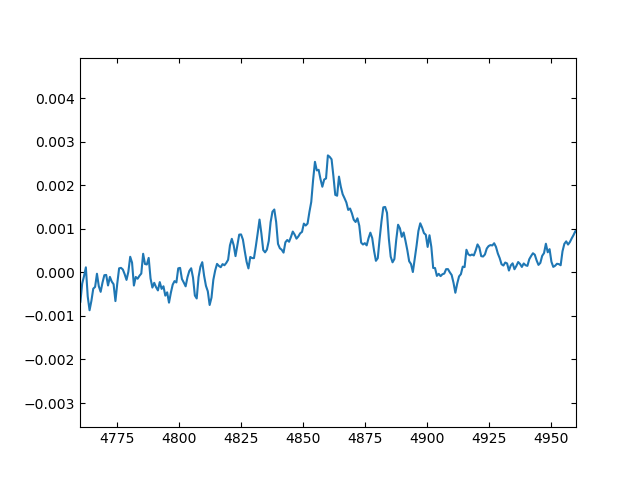

In [34]:
line_numbers = 1
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

* ${\rm [OIII]\lambda\lambda4959,5007}$

<IPython.core.display.Javascript object>


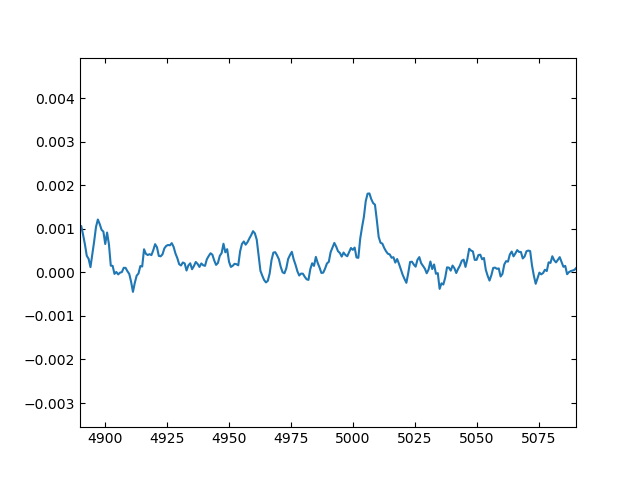

In [35]:
line_numbers = 2
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

## 4.3. Creating the broad component factor map

In [36]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

bfac = np.zeros(binned_spectrum.shape[1])
e_bfac = np.zeros(binned_spectrum.shape[1])
nmax_bin = data_vbin[yInd, xInd]
bfac[nmax_bin], e_bfac[nmax_bin] = 1.0, 0.0
print(f"Maximum - Bin {nmax_bin:d} : {bfac[0]:.3f} +/- {e_bfac[0]:.3f}")

for ibin in np.arange(binned_spectrum.shape[1]):
    fit_spectrum = dat[:, ibin]
    fit_variance = var[:, ibin]
    fac = gfac[data_vbin == ibin][0]
    
    if (ibin == nmax_bin):
        pass
    
    if (fac < 0.01):
        bfac[ibin] = 0.
        e_bfac[ibin] = 0.
    
    elif ((ibin != nmax_bin) & (fac >= 0.01)):
        spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
                   np.abs(wav_res-wav_fit[1]).argmin()]
        x_bin = wav_res[1] - wav_res[0]
        x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
        x_fit = np.log(x_wav)

        y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
        y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
        y_dat = y_loc / indices.shape[0]
        flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
        y_fit = x_wav * y_dat

        broad_fit = 0
        for i in np.arange(nbroad):
            exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
            broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

        # Model fitting
        def line_model2(x, *pars):
            narrow_comp = 0
            for i in np.arange(nlines-nbroad):
                narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
            broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
            return narrow_comp + broad_comp

        param = [line_sigma[0] / line_wav[0]]
        for j in np.arange(nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        param += [fac]
        
        try:
            popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
            perr = np.sqrt(np.diag(pcov))
            
            bfac[ibin] = popt[-1]*indices.shape[0]
            e_bfac[ibin] = perr[-1]*indices.shape[0]
        
        except RuntimeError:
            bfac[ibin] = param[-1]*indices.shape[0]
            e_bfac[ibin] = 0.0
        
        
    print(f"Bin {ibin:d} : {bfac[ibin]:.3f} +/- {e_bfac[ibin]:.3f}")


Maximum - Bin 0 : 1.000 +/- 0.000
Bin 0 : 1.000 +/- 0.000
Bin 1 : 0.974 +/- 0.040
Bin 2 : 0.959 +/- 0.043
Bin 3 : 0.978 +/- 0.039
Bin 4 : 0.819 +/- 0.028
Bin 5 : 0.806 +/- 0.032
Bin 6 : 0.884 +/- 0.032
Bin 7 : 0.714 +/- 0.028
Bin 8 : 0.851 +/- 0.041
Bin 9 : 0.572 +/- 0.033
Bin 10 : 0.667 +/- 0.032
Bin 11 : 0.473 +/- 0.033
Bin 12 : 0.534 +/- 0.031
Bin 13 : 0.538 +/- 0.028
Bin 14 : 0.386 +/- 0.031
Bin 15 : 0.669 +/- 0.034
Bin 16 : 0.271 +/- 0.030
Bin 17 : 0.313 +/- 0.030
Bin 18 : 0.316 +/- 0.032
Bin 19 : 0.380 +/- 0.031
Bin 20 : 0.216 +/- 0.026
Bin 21 : 0.216 +/- 0.031
Bin 22 : 0.307 +/- 0.029
Bin 23 : 0.600 +/- 0.024
Bin 24 : 0.418 +/- 0.025
Bin 25 : 0.709 +/- 0.029
Bin 26 : 0.178 +/- 0.023
Bin 27 : 0.189 +/- 0.024
Bin 28 : 0.116 +/- 0.024
Bin 29 : 0.143 +/- 0.023
Bin 30 : 0.169 +/- 0.027
Bin 31 : 0.252 +/- 0.024
Bin 32 : 0.134 +/- 0.019
Bin 33 : 0.126 +/- 0.018
Bin 34 : 0.096 +/- 0.023
Bin 35 : 0.149 +/- 0.021
Bin 36 : 0.115 +/- 0.030
Bin 37 : 0.110 +/- 0.024
Bin 38 : 0.098 +/- 0.021
B

Bin 317 : 0.124 +/- 0.018
Bin 318 : 0.038 +/- 0.018
Bin 319 : 0.048 +/- 0.021
Bin 320 : 0.076 +/- 0.019
Bin 321 : 0.023 +/- 0.015
Bin 322 : 0.089 +/- 0.019
Bin 323 : 0.214 +/- 0.097
Bin 324 : 0.071 +/- 0.016
Bin 325 : 0.070 +/- 0.017
Bin 326 : 0.046 +/- 0.023
Bin 327 : 0.103 +/- 0.015
Bin 328 : 0.000 +/- 0.000
Bin 329 : 0.000 +/- 0.000
Bin 330 : 0.041 +/- 0.019
Bin 331 : 0.047 +/- 0.016
Bin 332 : 0.048 +/- 0.034
Bin 333 : 0.046 +/- 0.018
Bin 334 : 0.021 +/- 0.027
Bin 335 : 0.055 +/- 0.018
Bin 336 : 0.081 +/- 0.017
Bin 337 : 0.149 +/- 0.033
Bin 338 : 0.043 +/- 0.028
Bin 339 : 0.041 +/- 0.032
Bin 340 : 0.177 +/- 0.068
Bin 341 : 0.092 +/- 0.033
Bin 342 : 0.000 +/- 0.000
Bin 343 : 0.112 +/- 0.032
Bin 344 : 0.498 +/- 0.117
Bin 345 : 1.039 +/- 0.113
Bin 346 : 0.030 +/- 0.044
Bin 347 : 0.293 +/- 0.064
Bin 348 : 0.000 +/- 0.000
Bin 349 : 0.119 +/- 0.058
Bin 350 : 0.067 +/- 0.089
Bin 351 : -0.053 +/- 0.091
Bin 352 : 0.448 +/- 0.160
Bin 353 : 0.181 +/- 0.109
Bin 354 : 0.000 +/- 0.000
Bin 355 : 0

<IPython.core.display.Javascript object>


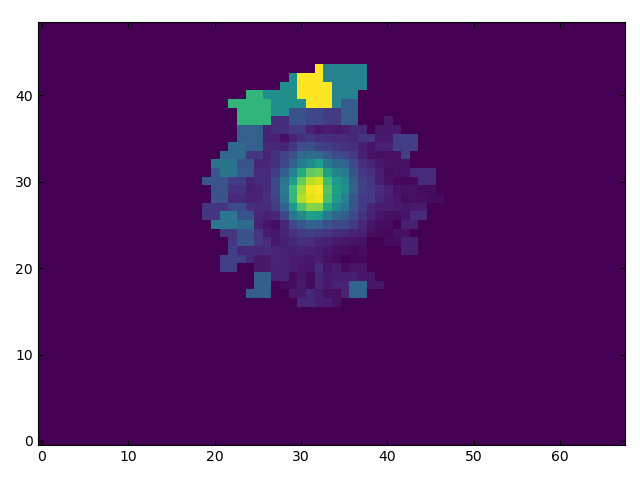

In [37]:
bfac_2D = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    if (b == -99):
        bf = 0.0
    else:
        bf = bfac[b]
    bfac_2D[data_vbin == b] = bf
        
fig, ax = plt.subplots()
ax.imshow(bfac_2D, origin = 'lower', vmin=0, vmax=1)
plt.tight_layout()
fits.writeto("bfac_2D.fits", bfac_2D, overwrite=True)